# RESNET 101 with longer training
source: https://www.kaggle.com/natevegh/pneumonia-detection-98-acc-fastai-2019-update

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
from fastai.metrics import error_rate
import os

In [3]:
import fastai_addons   #add plot2 extension -- learn.recorder.plot2()
from fastai_addons import interpretation_summary, plot_confusion_matrix, get_accuracy, \
                          analyze_confidence, accuracy_vs_threshold, show_incremental_accuracy, \
                          analyze_low_confidence, plot_confusion_matrix_thresh

In [4]:
model = models.resnet101
prefix = 'resnet101a_512_'
size=512

In [5]:
bs = 64//4

In [6]:
path = Path()/'data'/'chest_xray'
path.ls()

[WindowsPath('data/chest_xray/data'),
 WindowsPath('data/chest_xray/test'),
 WindowsPath('data/chest_xray/train'),
 WindowsPath('data/chest_xray/val')]

torch.Size([3, 1225, 1632])


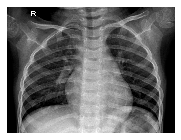

In [7]:
img = open_image(path/'val'/'NORMAL'/'NORMAL2-IM-1440-0001.jpeg')
print(img.data.shape)
img.show()

In [8]:
tfms = get_transforms()

In [9]:
np.random.seed(7)
data = ImageDataBunch.from_folder(path, 
                                  valid='val',
                                  valid_pct=0.2,
                                  size=size, bs=bs,
                                  ds_tfms=tfms).normalize(imagenet_stats)

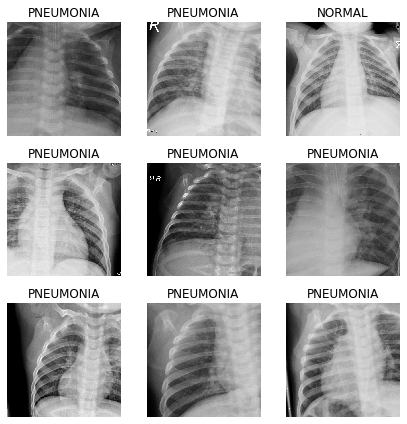

In [10]:
data.show_batch(3, figsize=(6,6))

In [11]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['NORMAL', 'PNEUMONIA'], 2, 4685, 1171)

# Train Model Head

In [12]:
learn = cnn_learner(data, model, metrics=error_rate, 
                    model_dir=(path/'models')).to_fp16()

In [27]:
learn.fit_one_cycle(12)

epoch,train_loss,valid_loss,error_rate,time
0,0.263571,0.163868,0.058070,02:29
1,0.201870,0.169798,0.068318,02:30
2,0.175386,0.112165,0.041845,02:30
3,0.184742,0.134353,0.052946,02:30
4,0.156353,0.090827,0.033305,02:29
5,0.098497,0.087986,0.030743,02:30
6,0.113704,0.071508,0.029035,02:30
7,0.104886,0.064600,0.018787,02:30
8,0.101623,0.081203,0.027327,02:30
9,0.074614,0.062361,0.021349,02:29


In [13]:
#learn.save(prefix+'stage-1')

In [17]:
learn.load(prefix+'stage-1').to_fp16()

Learner(data=ImageDataBunch;

Train: LabelList (4685 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: data\chest_xray;

Valid: LabelList (1171 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA
Path: data\chest_xray;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [18]:
save_name = prefix+'stage-2'

learn.unfreeze()
learn.to_fp16()
# learn.lr_find()
# learn.recorder.plot2()
# learn.recorder.plot(k=5, suggestion=True)

Learner(data=ImageDataBunch;

Train: LabelList (4685 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: data\chest_xray;

Valid: LabelList (1171 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA,PNEUMONIA
Path: data\chest_xray;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [21]:
learn.fit_one_cycle(45, max_lr=slice(3e-5, 3e-4),
                    callbacks=[SaveModelCallback(learn, every='improvement', name=save_name)])

epoch,train_loss,valid_loss,error_rate,time
0,0.052662,0.072685,0.029889,03:03
1,0.062872,0.065008,0.021349,03:00
2,0.107553,0.068988,0.023057,03:03
3,0.086407,0.083555,0.027327,03:05
4,0.097914,0.107494,0.039283,02:57
5,0.101137,0.107981,0.036721,02:57
6,0.121433,0.070607,0.029889,02:59
7,0.107916,0.066538,0.023057,02:57
8,0.106091,0.060738,0.017079,03:00
9,0.102385,0.071840,0.023911,03:05


Better model found at epoch 0 with valid_loss value: 0.0726853758096695.
Better model found at epoch 1 with valid_loss value: 0.06500815600156784.
Better model found at epoch 8 with valid_loss value: 0.06073839217424393.
Better model found at epoch 23 with valid_loss value: 0.06015624478459358.
Better model found at epoch 24 with valid_loss value: 0.0581224225461483.
Better model found at epoch 25 with valid_loss value: 0.05459114536643028.


In [22]:
learn.save(prefix+'stage-2')

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          97%         96%        99%        0.97
PNEUMONIA       99%         99%        96%        0.99


Overall Accuracy: 98.21%
Accuracy: 98.21%   Error: 1.79%   Unknown: 0.00%   @ Threshold: 0.00

Confidence Histograms @ t=0.0


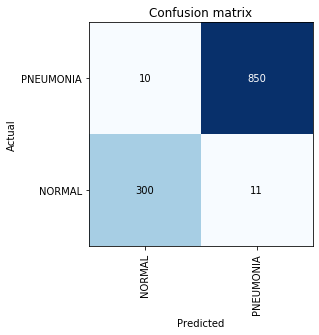

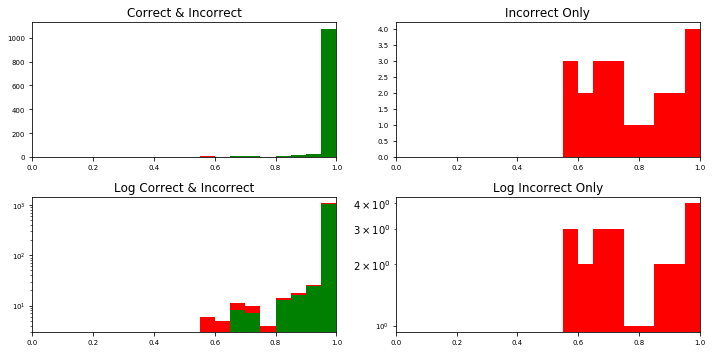

In [26]:
interpretation_summary(interp)
plot_confusion_matrix(interp)
analyze_confidence(interp)

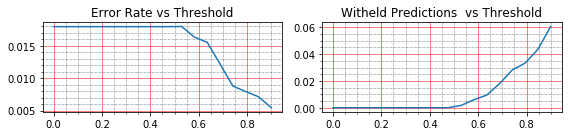

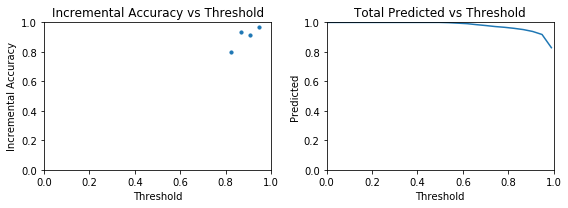

In [24]:
accuracy_vs_threshold(interp)
show_incremental_accuracy(interp)

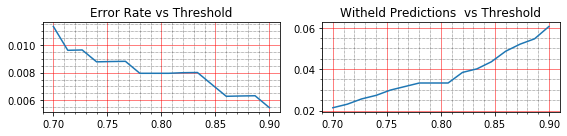

In [25]:
accuracy_vs_threshold(interp, threshold_range=(0.7, 0.9, 4*4))

## Show updated accuracy after Thresholding

            Precision
           Specificity     Recall   Sensitivity    F1
NORMAL          98%         99%        99%        0.98
PNEUMONIA      100%         99%        99%        0.99


Overall Accuracy: 99.20%
Accuracy: 99.20%   Error: 0.80%   Unknown: 3.33%   @ Threshold: 0.80

Confidence Histograms @ t=0.8


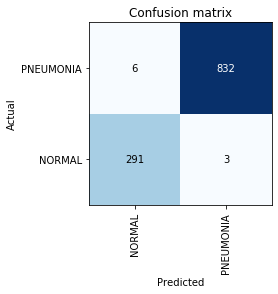

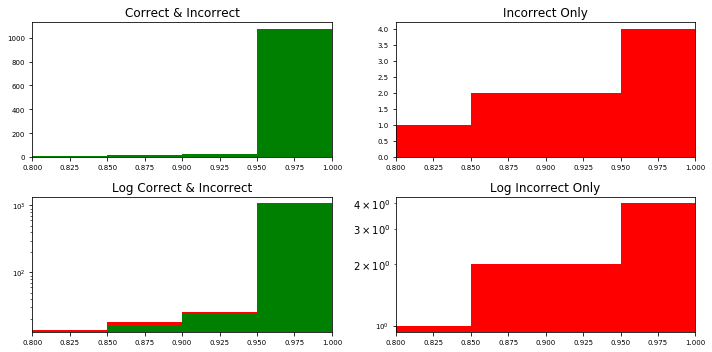

In [23]:
interpretation_summary(interp, thresh=0.8)
plot_confusion_matrix_thresh(interp, thresh=0.8)
analyze_confidence(interp, thresh=0.8)

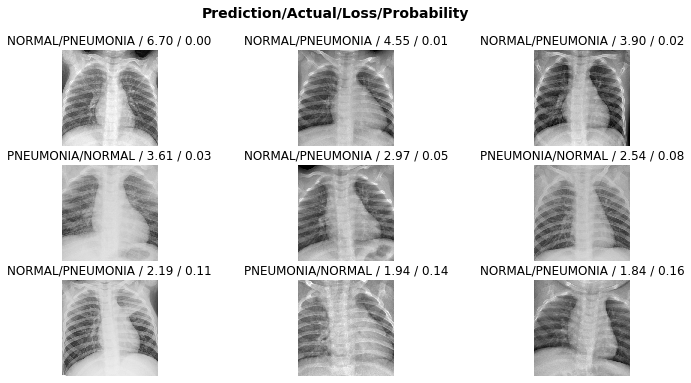

In [22]:
interp.plot_top_losses(9, figsize=(12,6))